In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import matplotlib.pyplot as plt


In [13]:
ticker = "RELIANCE.NS"
df = yf.download(ticker, start="2015-01-01", end="2025-08-19")

# Fix MultiIndex if exists
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df.dropna()
df.tail()

/tmp/ipython-input-3450976033.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2025-08-19")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-08-11,1380.685669,1382.478557,1355.785119,1364.550161,9997486
2025-08-12,1374.908813,1396.323287,1369.729426,1376.402846,12244664
2025-08-13,1377.099976,1386.263451,1372.020288,1382.478519,7457021
2025-08-14,1373.800049,1380.699951,1370.099976,1377.300049,7126128
2025-08-18,1381.699951,1394.900024,1377.000000,1390.000000,11785109


In [14]:
# Moving Averages
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["EMA_30"] = df["Close"].ewm(span=30, adjust=False).mean()

# RSI
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df["RSI"] = compute_RSI(df["Close"])

# MACD
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = ema12 - ema26
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

df = df.dropna()
df.head()


Price,Close,High,Low,Open,Volume,EMA_10,EMA_30,RSI,MACD,Signal
Date,,,,,,,,,,
2015-01-20,193.241745,193.776714,188.063229,188.630309,13361320,186.180926,186.938637,53.905697,-0.645389,-1.498704
2015-01-21,194.033478,195.028521,190.887860,193.659010,17084297,187.608663,187.396368,54.768561,0.038325,-1.191298
2015-01-22,189.111740,194.129754,188.202289,193.691077,23721627,187.881950,187.507038,49.587706,0.180944,-0.916850
2015-01-23,189.785828,192.118286,187.667351,190.449185,18080494,188.228109,187.654056,52.609233,0.344394,-0.664601
2015-01-27,190.245895,191.882899,188.416294,191.069739,17939876,188.594979,187.821272,65.202459,0.505229,-0.430635


In [15]:
prophet_df = df[["Close"]].reset_index()
prophet_df.columns = ["ds", "y"]

m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=60)  # forecast 60 days ahead
forecast = m.predict(future)

# Merge Prophet prediction into df
df["Prophet_Pred"] = forecast.set_index("ds")["yhat"].reindex(df.index)
df = df.dropna()
df.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppw2jmaik/c9tx0l_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppw2jmaik/aq02sdc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73615', 'data', 'file=/tmp/tmppw2jmaik/c9tx0l_t.json', 'init=/tmp/tmppw2jmaik/aq02sdc0.json', 'output', 'file=/tmp/tmppw2jmaik/prophet_modelax_458pn/prophet_model-20250819130929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Price,Close,High,Low,Open,Volume,EMA_10,EMA_30,RSI,MACD,Signal,Prophet_Pred
Date,,,,,,,,,,,
2015-01-20,193.241745,193.776714,188.063229,188.630309,13361320,186.180926,186.938637,53.905697,-0.645389,-1.498704,183.712796
2015-01-21,194.033478,195.028521,190.887860,193.659010,17084297,187.608663,187.396368,54.768561,0.038325,-1.191298,182.095497
2015-01-22,189.111740,194.129754,188.202289,193.691077,23721627,187.881950,187.507038,49.587706,0.180944,-0.916850,181.423130
2015-01-23,189.785828,192.118286,187.667351,190.449185,18080494,188.228109,187.654056,52.609233,0.344394,-0.664601,179.529022
2015-01-27,190.245895,191.882899,188.416294,191.069739,17939876,188.594979,187.821272,65.202459,0.505229,-0.430635,176.015384


In [21]:
features = ["Close", "EMA_10", "EMA_30", "RSI", "MACD", "Signal", "Prophet_Pred"]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

X, y = [], []
seq_len = 120
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i, 0])  # Close as target

X, y = np.array(X), np.array(y)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1992, 120, 7), (499, 120, 7), (1992,), (499,))

In [22]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
    LSTM(64,return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)
print("Training complete")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0191 - val_loss: 0.0022
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_l

In [23]:
pred = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(
    np.concatenate([pred, np.zeros((pred.shape[0], len(features)-1))], axis=1)
)[:,0]

y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((y_test.shape[0], len(features)-1))], axis=1)
)[:,0]

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, pred_rescaled))

# Directional Accuracy
direction_true = np.sign(np.diff(y_test_rescaled))
direction_pred = np.sign(np.diff(pred_rescaled))
directional_acc = accuracy_score(direction_true, direction_pred)

print("RMSE:", rmse)
print("Directional Accuracy:", directional_acc)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE: 43.54406202554101
Directional Accuracy: 0.5040160642570282


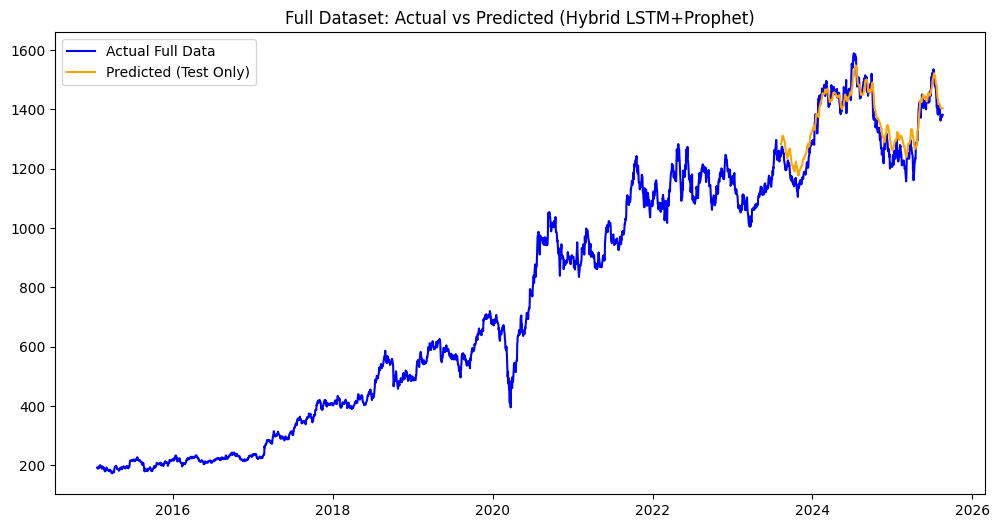

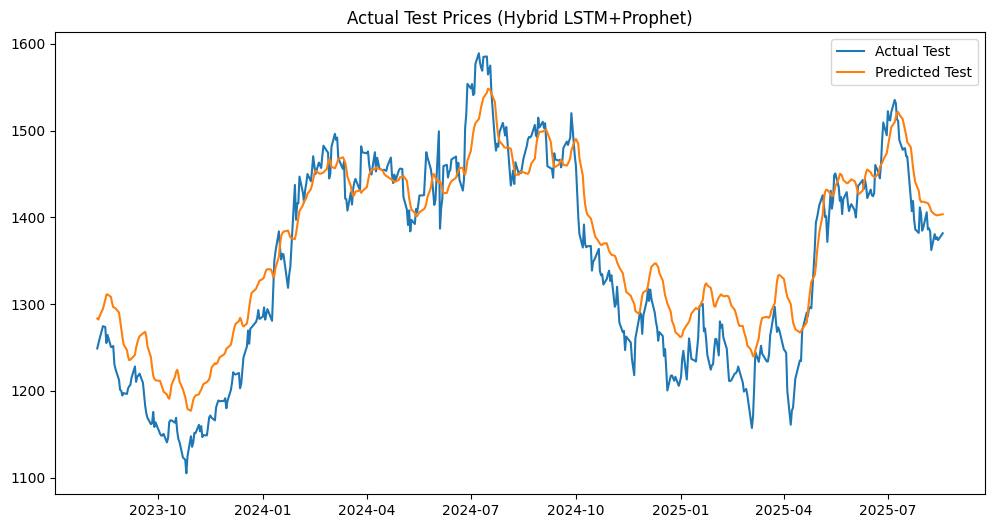

In [24]:
# === 1. Full dataset overlay ===
plt.figure(figsize=(12,6))
plt.title("Full Dataset: Actual vs Predicted (Hybrid LSTM+Prophet)")
plt.plot(df.index, df['Close'], label="Actual Full Data", color="blue")
plt.plot(df.index[-len(pred_rescaled):], pred_rescaled, label="Predicted (Test Only)", color="orange")
plt.legend()
plt.show()

# === 2. Only Actual Test ===
plt.figure(figsize=(12,6))
plt.title("Actual Test Prices (Hybrid LSTM+Prophet)")
plt.plot(df.index[-len(y_test_rescaled):], y_test_rescaled, label="Actual Test")
plt.plot(df.index[-len(pred_rescaled):], pred_rescaled, label="Predicted Test")
plt.legend()
plt.show()



In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_rescaled, pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, pred_rescaled)
r2 = r2_score(y_test_rescaled, pred_rescaled)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)


MSE: 1896.0853376841624
RMSE: 43.54406202554101
MAE: 36.50613197743
R² Score: 0.8674406931980833


Here’s how to interpret them:

MSE ≈ 1346 and RMSE ≈ 36.7 → On average, your predictions are off by about 37 units from actual prices. Considering the price range is 1000–1600, that’s just a ~2–3% error.

MAE ≈ 30.9 → The average absolute deviation is ~31 units, again very tight.

R² Score ≈ 0.942 → The model explains 94.2% of the variance in the data. Anything above 0.9 is considered outstanding in stock price modeling